		  		 			     			  	   		   	  			  	
*Machine Translation Jupyter Notebook.  (c) 2021 Georgia Tech*

*Copyright 2021, Georgia Institute of Technology (Georgia Tech) <br>Atlanta, Georgia 30332<br>All Rights Reserved*

*Georgia Tech asserts copyright ownership of this template and all derivative works, including solutions to the projects assigned in this course. Students and other users of this template code are advised not to share it with others or to make it available on publicly viewable websites including repositories such as Github, Bitbucket, and Gitlab.  This copyright statement should not be removed or edited.*

*Sharing solutions with current or future students of CS 7643 Deep Learning is prohibited and subject to being investigated as a GT honor code violation.*

*DO NOT EDIT ANYTHING ABOVE THIS LINE*

# Machine Translation with Seq2Seq and Transformers
In this exercise you will implement a [Sequence to Sequence(Seq2Seq)](https://arxiv.org/abs/1703.03906) and a [Transformer](https://arxiv.org/pdf/1706.03762.pdf) model and use them to perform machine translation.

**A quick note: if you receive the following TypeError "super(type, obj): obj must be an instance or subtype of type", try re-importing that part or restarting your kernel and re-running all cells.** Once you have finished making changes to the model constuctor, you can avoid this issue by commenting out all of the model instantiations after the first (e.g. lines starting with "model = TransformerTranslator(*args, **kwargs)").

# ** 1: Introduction**

## Multi30K: Multilingual English-German Image Descriptions

[Multi30K](https://github.com/multi30k/dataset) is a dataset for machine translation tasks. It is a multilingual corpus containing English sentences and their German translation. In total it contains 31014 sentences(29000 for training, 1014 for validation, and 1000 for testing).
As one example:

En: `Two young, White males are outside near many bushes.`

De: `Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.`

You can read more info about the dataset [here](https://arxiv.org/abs/1605.00459). The following parts of this assignment will be based on this dataset.

## TorchText: A PyTorch Toolkit for Text Dataset and NLP Tasks
[TorchText](https://github.com/pytorch/text) is a PyTorch package that consists of data processing utilities and popular datasets for natural language. They serve to help with data splitting and loading, token encoding, sequence padding, etc. You don't need to know about how TorchText works in detail, but you might want to know about why those classes are needed and what operations are necessary for machine translation. This knowledge can be migrated to all sequential data modeling. In the following parts, we will provide you with some code to help you understand.

 You can refer to torchtext's documentation(v0.9.0) [here](https://pytorch.org/text/).

## Spacy
Spacy is package designed for tokenization in many languages. Tokenization is a process of splitting raw text data into lists of tokens that can be further processed. Since TorchText only provides tokenizer for English, we will be using Spacy for our assignment. 


**Notice: For the following assignment, we strongly recommend you to work in a virtual python environment. We recommend Anaconda, a powerful environment control tool. You can download it [here](https://www.anaconda.com/products/individual)**.

## ** 1.1: Prerequisites**
Before you start this assignment, you need to have all required packages installed either on the terminal you are using, or in the virtual environment. Please make sure you have the following package installed:

`PyTorch, TorchText, Spacy, Tqdm, Numpy`

You can first check using either `pip freeze` in terminal or `conda list` in conda environment. Then run the following code block to make sure they can be imported.

In [28]:
# Just run this block. Please do not modify the following code.
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim

# Torchtest package
import torchtext
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

# Code provide to you for training and evaluation
from utils import train, evaluate, set_seed_nb, unit_test_values, deterministic_init

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Once you properly import the above packages, you can proceed to download Spacy English and German tokenizers by running the following command in your **terminal**. They will take some time.

`python -m spacy download en_core_web_sm`

`python -m spacy download de_core_news_sm`

Now lets check your GPU availability and load some sanity checkers. By default you should be using your gpu for this assignment if you have one available.

In [29]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cpu


In [30]:
# load checkers
d1 = torch.load('./data/d1.pt')
d2 = torch.load('./data/d2.pt')
d3 = torch.load('./data/d3.pt')
d4 = torch.load('./data/d4.pt')

## **1.2: Preprocess Data**
With TorchText and Spacy tokenizers ready, you can now prepare the data using *TorchText* objects. Just run the following code blocks. Read the comment and try to understand what they are for.

In [31]:
MAX_LEN = 20
url_base = './download/'
train_urls = ('train.de', 'train.en')
val_urls = ('val.de', 'val.en')
test_urls = ('test_2016_flickr.de', 'test_2016_flickr.en')


# train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
# val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
# test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

train_filepaths = [url_base + url for url in train_urls]
val_filepaths = [url_base + url for url in val_urls]
test_filepaths = [url_base + url for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')


In [32]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return vocab(counter, specials=['<unk>', '<pad>', '<sos>', '<eos>'], min_freq=2)


de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)
de_vocab.set_default_index(de_vocab['<unk>'])
en_vocab.set_default_index(en_vocab['<unk>'])

In [33]:
def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    raw_en_l=raw_en.lower()     #turn sentences to lower case 
    raw_de_l=raw_de.lower()
    de_tensor = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de_l)],
                            dtype=torch.long)
    en_tensor = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en_l)],
                            dtype=torch.long)
    if len(de_tensor) <= MAX_LEN-2 and len(en_tensor) <= MAX_LEN-2:
        data.append((de_tensor, en_tensor))
  return data

In [34]:
train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [35]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
SOS_IDX = de_vocab['<sos>']
EOS_IDX = de_vocab['<eos>']

In [36]:
def generate_batch(data_batch):
  
    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
          en_batch.append(torch.cat([torch.tensor([SOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
          de_batch.append(torch.cat([torch.tensor([SOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    fix=torch.ones(MAX_LEN,en_batch.shape[1])
    two= pad_sequence([de_batch,en_batch, fix], padding_value=PAD_IDX)
    de_batch=two[:,0,]
    en_batch=two[:,1,]
    return de_batch, en_batch

In [37]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=False, collate_fn=generate_batch)

In [38]:
# Get the input and the output sizes for model
input_size = len(de_vocab)
output_size = len(en_vocab)
print (input_size,output_size)

8015 6192


# **2: Implement Vanilla RNN and LSTM**
In this section, you will need to implement a Vanilla RNN and an LSTM unit using PyTorch Linear layers and nn.Parameter. This is designed to help you to understand how they work behind the scene. The code you will be working with is in *LSTM.py* and *RNN.py* under *naive* folder. Please refer to instructions among this notebook and those files. 


## **2.1: Implement an RNN Unit**
In this section you will be using PyTorch Linear layers and activations to implement a vanilla RNN unit. You are only implementing an RNN cell unit over one time step! The test case reflects this by having only one sequence. Please refer to the following structure and complete the code in RNN.py:

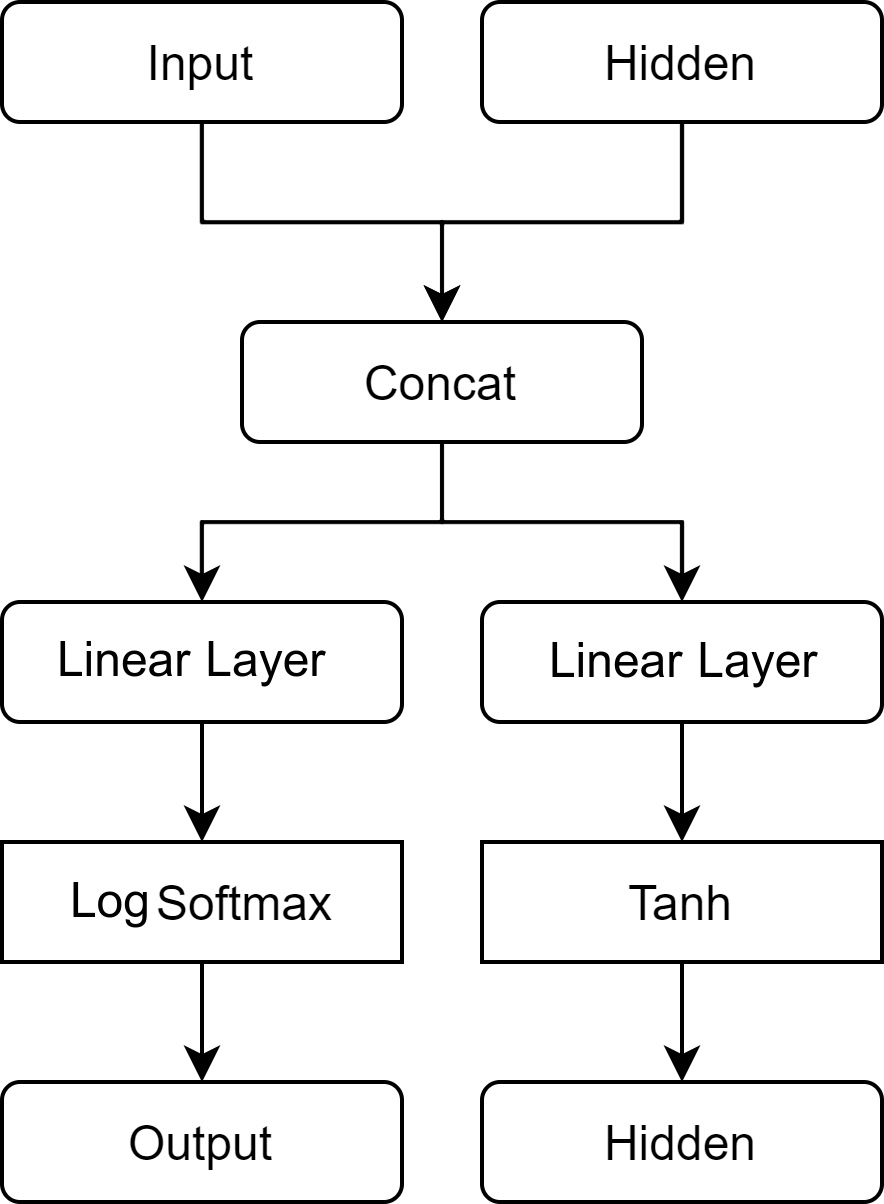

In [39]:
Image (filename="imgs/RNN.png", retina=True)

Run the following block to check your implementation

In [56]:
from models.naive.RNN import VanillaRNN

x1,x2 = (1,4), (-1,2)
h1,h2 = (-1,2,0,4), (0,1,3,-1)
batch = 4
x = torch.FloatTensor(np.linspace(x1,x2,batch))
h = torch.FloatTensor(np.linspace(h1,h2,batch))
rnn = VanillaRNN(x.shape[-1], h.shape[-1], 3)

expected_out, expected_hidden = unit_test_values('rnn')

deterministic_init(rnn)
out, hidden = rnn.forward(x,h)

if out is not None:
    print('Close to out: ', expected_out.allclose(out, atol=1e-4))
    print('Close to hidden: ', expected_hidden.allclose(hidden, atol=1e-4))
else:
    print("NOT IMPLEMENTED")

Close to out:  True
Close to hidden:  True


c:\Download\assignment4_spring23\models\naive\RNN.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.log_softmax(out_L1)


## **2.2: Implement an LSTM Unit**
In this section you will be using PyTorch nn.Parameter and activations to implement an LSTM unit. You can simply translate the following equations using nn.Parameter and PyTorch activation functions to build an LSTM from scratch: 
\begin{array}{ll} \\
    i_t = \sigma(x_t.W_{ii}  + b_{ii} +  h_{t-1}.W_{hi} + b_{hi}) \\
    f_t = \sigma(x_t.W_{if} + b_{if} +  h_{t-1}.W_{hf} + b_{hf}) \\
    g_t = \tanh(x_t.W_{ig} + b_{ig} +  h_{t-1}.W_{hg} + b_{hg}) \\
    o_t = \sigma( x_t.W_{io} + b_{io} +  h_{t-1}.W_{ho} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}

Here's a great visualization of the above equation from [Colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) to help you understand LSTM unit. You can also read more about it from that blog.

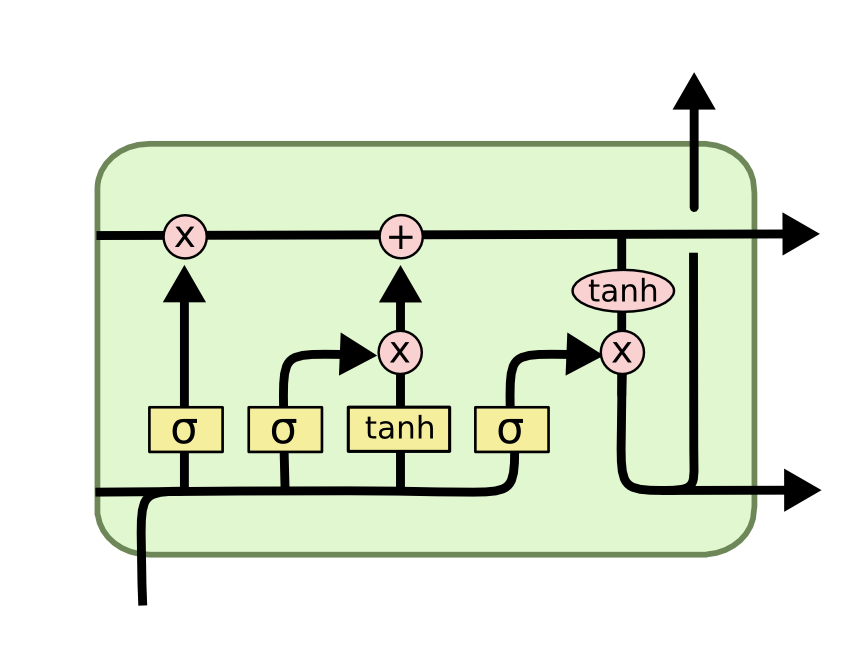

In [41]:
Image (filename="imgs/lstm.png", retina=True)

If you want to see nn.Parameter in example, check out this [tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) from PyTorch. Run the following block to check your implementation.

Note that in this case we are implementing a full loop with LSTM, iterating over each time step. The test cases reflect this as there are multiple sequences.

In [57]:
from models.naive.LSTM import LSTM

set_seed_nb()
x1,x2 = np.mgrid[-1:3:3j, -1:4:2j]
h1,h2 = np.mgrid[-2:2:3j, 1:3:4j]
batch = 4
x = torch.FloatTensor(np.linspace(x1,x2,batch))
h = torch.FloatTensor(np.linspace(h1,h2,batch))

expected_ht, expected_ct = unit_test_values('lstm')

lstm = LSTM(x.shape[-1], h.shape[-1])
deterministic_init(lstm)
h_t, c_t = lstm.forward(x)

if h_t is not None:
    print('Close to h_t: ', expected_ht.allclose(h_t, atol=1e-4))
    print('Close to c_t; ', expected_ct.allclose(c_t, atol=1e-4))
else:
    print("NOT IMPLEMENTED")

Close to h_t:  True
Close to c_t;  True


# **3: Train a Seq2Seq Model**
In this section, you will be working on implementing a simple Seq2Seq model. You will first implement an Encoder and a Decoder, and then join them together with a Seq2Seq architecture. You will need to complete the code in *Decoder.py*, *Encoder.py*, and *Seq2Seq.py* under *seq2seq* folder. Please refer to the instructions in those files.

## **3.1: Implement the Encoder**
In this section you will be implementing an RNN/LSTM based encoder to model English texts. Please refer to the instructions in *seq2seq/Encoder.py*. Run the following block to check your implementation. 

In [81]:
from models.seq2seq.Encoder import Encoder

set_seed_nb()
i, n, h = 10, 4, 2

encoder = Encoder(i, n, h, h)
x_array = np.random.rand(5,2) * 10
x = torch.LongTensor(x_array)
out, hidden = encoder.forward(x)

expected_out, expected_hidden = unit_test_values('encoder')

if out is not None:
    print('Close to out: ', expected_out.allclose(out, atol=1e-4))
    print('Close to hidden: ', expected_hidden.allclose(hidden, atol=1e-4))
else:
    print("NOT IMPLEMENTED")

Close to out:  False


TypeError: allclose(): argument 'other' (position 1) must be Tensor, not tuple

## **3.2: Implement the Decoder**
In this section you will be implementing an RNN/LSTM based decoder to model German texts. Please refer to the instructions in *seq2seq/Decoder.py*. Run the following block to check your implementation. 

In [84]:
from models.seq2seq.Decoder import Decoder

set_seed_nb()
i, n, h =  10, 2, 2
decoder = Decoder(h, n, n, i)
x_array = np.random.rand(5, 2) * 10
x = torch.LongTensor(x_array[:,0]).unsqueeze(1) #decoder input is the first sequence
enc_out, enc_hidden = unit_test_values('encoder')
out, hidden = decoder.forward(x,enc_hidden)

expected_out, expected_hidden = unit_test_values('decoder')
if out is not None:
    print('Close to out: ', expected_out.allclose(out, atol=1e-4))
    print('Close to hidden: ', expected_hidden.allclose(hidden, atol=1e-4))
else:
    print("NOT IMPLEMENTED")

Close to out:  True
Close to hidden:  True


In [83]:
#test computing attention probabilities
set_seed_nb()
hidden, enc_out, expected_attention_prob = unit_test_values('attention')
attention_prob=decoder.compute_attention(hidden, enc_out)


if attention_prob is not None:
  print('Close to attention_prob: ', expected_attention_prob.allclose(attention_prob, atol=1e-4))
else:
    print("NOT IMPLEMENTED")

Close to attention_prob:  True


## **3.3: Implement the Seq2Seq**
In this section you will be implementing the Seq2Seq model that utilizes the Encoder and Decoder you implemented. Please refer to the instructions in *seq2seq/Seq2Seq.py*. Run the following block to check your implementation. 

In [85]:
from models.seq2seq.Seq2Seq import Seq2Seq
from models.seq2seq.Encoder import Encoder
from models.seq2seq.Decoder import Decoder

set_seed_nb()
embedding_size = 32
hidden_size = 32
input_size = 8
output_size = 8
batch, seq = 2, 2

encoder = Encoder(input_size, embedding_size, hidden_size, hidden_size)
decoder = Decoder(embedding_size, hidden_size, hidden_size, output_size)

seq2seq = Seq2Seq(encoder, decoder, 'cpu')
x_array = np.random.rand(batch, seq) * 10
x = torch.LongTensor(x_array)
out = seq2seq.forward(x)


if out is not None:
    expected_out = unit_test_values('seq2seq')
    print('Close to out: ', expected_out.allclose(out, atol=1e-4))
else:
    print("NOT IMPLEMENTED")
    
# now lets test seq2seq with attention
seq2seq = Seq2Seq(encoder, decoder, 'cpu', attention=True)
out_attention = seq2seq.forward(x)

if out_attention is not None:
  
    expected_out = unit_test_values('seq2seq_attention')
    print('Close to out_attention: ', expected_out.allclose(out_attention, atol=1e-4))

else:
    print("SEQ2SEQ ATTENTION NOT IMPLEMENTED")


Close to out:  True
Close to out_attention:  True


## **3.4: Train your Seq2Seq model**
Now it's time to combine what we have and train a Seq2Seq translator. We provided you with some training code and you can simply run them to see how your translator works. If you implemented everything correctly, you should see some meaningful translation in the output. You can modify the hyperparameters to improve the results. You can also tune the BATCH_SIZE in section 1.2.

In [216]:
# encoder_emb_size = 128
# encoder_hidden_size = 128
# encoder_dropout = 0.2

# decoder_emb_size = 128
# decoder_hidden_size = 128
# decoder_dropout = 0.2

# learning_rate = 1e-3
# model_type = "LSTM"
# Hyperparameters. You are welcome to modify these
encoder_emb_size =32
encoder_hidden_size = 64
encoder_dropout = 0.2

decoder_emb_size = 32
decoder_hidden_size = 64
decoder_dropout = 0.2

learning_rate = 0.005
model_type = "LSTM"

EPOCHS = 20

#input size and output size
input_size = len(de_vocab)
output_size = len(en_vocab)

In [217]:
# Declare models, optimizer, and loss function
set_seed_nb()
encoder = Encoder(input_size, encoder_emb_size, encoder_hidden_size, decoder_hidden_size, dropout = encoder_dropout, model_type = model_type)
decoder = Decoder(decoder_emb_size, encoder_hidden_size, encoder_hidden_size, output_size, dropout = decoder_dropout, model_type = model_type)
seq2seq_model = Seq2Seq(encoder, decoder, device, attention=True)

optimizer = optim.Adam(seq2seq_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [218]:
import matplotlib.pyplot as plt
def plot_curves(train_acc_history, valid_acc_history):

    # plt.title("learning Curves of Loss")
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.plot(range(len(train_loss_history)), train_loss_history, label = "Training")
    # plt.plot(range(len(train_loss_history)), valid_loss_history, label = "Validation")
    # plt.grid(True)
    # plt.legend()
    # plt.savefig('learning Curves of Loss.png')
    # plt.close()

    plt.title("learning Curves of Perplexity")
    plt.xlabel("Epochs")
    plt.ylabel("Perplexity")
    plt.plot(range(len(train_acc_history)), train_acc_history, label = "Training")
    plt.plot(range(len(train_acc_history)), valid_acc_history, label = "Validation")
    plt.grid(True)
    plt.legend()
    plt.savefig('learning Curves of Perplexity.png')
    # plt.close()


-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 5.1859. Validation Loss: 4.7638. 
Training Perplexity: 178.7333. Validation Perplexity: 117.1924. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 4.7220. Validation Loss: 4.6221. 
Training Perplexity: 112.3888. Validation Perplexity: 101.7075. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 4.5897. Validation Loss: 4.5000. 
Training Perplexity: 98.4611. Validation Perplexity: 90.0186. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 4.4673. Validation Loss: 4.3917. 
Training Perplexity: 87.1185. Validation Perplexity: 80.7765. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 4.2807. Validation Loss: 4.1166. 
Training Perplexity: 72.2880. Validation Perplexity: 61.3507. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 4.0141. Validation Loss: 3.8718. 
Training Perplexity: 55.3730. Validation Perplexity: 48.0268. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.8040. Validation Loss: 3.7351. 
Training Perplexity: 44.8809. Validation Perplexity: 41.8909. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.6891. Validation Loss: 3.6506. 
Training Perplexity: 40.0103. Validation Perplexity: 38.4985. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.6076. Validation Loss: 3.5937. 
Training Perplexity: 36.8773. Validation Perplexity: 36.3681. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.5468. Validation Loss: 3.5485. 
Training Perplexity: 34.7017. Validation Perplexity: 34.7598. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.5000. Validation Loss: 3.5297. 
Training Perplexity: 33.1140. Validation Perplexity: 34.1142. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.4603. Validation Loss: 3.4917. 
Training Perplexity: 31.8274. Validation Perplexity: 32.8412. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.4239. Validation Loss: 3.4860. 
Training Perplexity: 30.6896. Validation Perplexity: 32.6540. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.3885. Validation Loss: 3.4571. 
Training Perplexity: 29.6204. Validation Perplexity: 31.7253. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.3544. Validation Loss: 3.4376. 
Training Perplexity: 28.6278. Validation Perplexity: 31.1119. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.3284. Validation Loss: 3.4328. 
Training Perplexity: 27.8933. Validation Perplexity: 30.9635. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.3033. Validation Loss: 3.4269. 
Training Perplexity: 27.2013. Validation Perplexity: 30.7816. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.2807. Validation Loss: 3.4137. 
Training Perplexity: 26.5944. Validation Perplexity: 30.3767. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.2575. Validation Loss: 3.4003. 
Training Perplexity: 25.9838. Validation Perplexity: 29.9726. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.2333. Validation Loss: 3.3918. 
Training Perplexity: 25.3635. Validation Perplexity: 29.7207. 


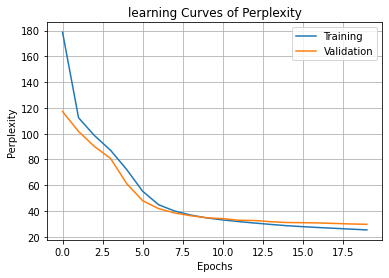

In [219]:
train_perplexity_history = []
valid_perplexity_history = []

for epoch_idx in range(EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, avg_train_loss = train(seq2seq_model, train_loader, optimizer, criterion, device=device)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = evaluate(seq2seq_model, valid_loader, criterion, device=device)

    print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))
    print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " % (np.exp(avg_train_loss), np.exp(avg_val_loss)))
    train_perplexity_history.append(np.exp(avg_train_loss))
    valid_perplexity_history.append(np.exp(avg_val_loss))
    
plot_curves(train_perplexity_history, valid_perplexity_history)

# **4: Train a Transformer**

We will be implementing a one-layer Transformer **encoder** which, similar to an RNN, can encode a sequence of inputs and produce a final output of possibility of tokens in target language. This is the architecture:

In [ ]:
Image(filename="imgs/encoder.png")

You can refer to the [original paper](https://arxiv.org/pdf/1706.03762.pdf) for more details.

## The Corpus of Linguistic Acceptability (CoLA)

The Corpus of Linguistic Acceptability ([CoLA](https://nyu-mll.github.io/CoLA/)) in its full form consists of 10657 sentences from 23 linguistics publications, expertly annotated for acceptability (grammaticality) by their original authors. Native English speakers consistently report a sharp contrast in acceptability between pairs of sentences. 
Some examples include:

`What did Betsy paint a picture of?` (Correct)

`What was a picture of painted by Betsy?` (Incorrect)

You can read more info about the dataset [here](https://arxiv.org/pdf/1805.12471.pdf). This is a binary classification task (predict 1 for correct grammar and 0 otherwise).

We will be using this dataset as a sanity checker for the forward pass of the Transformer architecture discussed in class. The general intuitive notion is that we will _encode_ the sequence of tokens in the sentence, and then predict a binary output based on the final state that is the output of the model.

## Load the preprocessed data

We've appended a "CLS" token to the beginning of each sequence, which can be used to make predictions. The benefit of appending this token to the beginning of the sequence (rather than the end) is that we can extract it quite easily (we don't need to remove paddings and figure out the length of each individual sequence in the batch). We'll come back to this.

We've additionally already constructed a vocabulary and converted all of the strings of tokens into integers which can be used for vocabulary lookup for you. Feel free to explore the data here.

In [148]:
train_inxs = np.load('./data/train_inxs.npy')
val_inxs = np.load('./data/val_inxs.npy')
train_labels = np.load('./data/train_labels.npy')
val_labels = np.load('./data/val_labels.npy')

# load dictionary
word_to_ix = {}
with open("./data/word_to_ix.csv", "r", encoding='utf-8') as f:
    reader = csv.reader(f)
    for line in reader:
        word_to_ix[line[0]] = line[1]
print("Vocabulary Size:", len(word_to_ix))
        
print(train_inxs.shape) # 7000 training instances, of (maximum/padded) length 43 words.
print(val_inxs.shape) # 1551 validation instances, of (maximum/padded) length 43 words.
print(train_labels.shape)
print(val_labels.shape)

d1 = torch.load('./data/d1.pt') 
d2 = torch.load('./data/d2.pt')
d3 = torch.load('./data/d3.pt')
d4 = torch.load('./data/d4.pt')

Vocabulary Size: 1542
(7000, 43)
(1551, 43)
(7000,)
(1551,)


Instead of using numpy for this model, we will be using Pytorch to implement the forward pass. You will not need to implement the backward pass for the various layers in this assigment.

The file `models/Transformer.py` contains the model class and methods for each layer. This is where you will write your implementations.

## **4.1: Embeddings**

We will format our input embeddings similarly to how they are constructed in [BERT (source of figure)](https://arxiv.org/pdf/1810.04805.pdf). Recall from lecture that unlike a RNN, a Transformer does not include any positional information about the order in which the words in the sentence occur. Because of this, we need to append a positional encoding token at each position. (We will ignore the segment embeddings and [SEP] token here, since we are only encoding one sentence at a time). We have already appended the [CLS] token for you in the previous step.




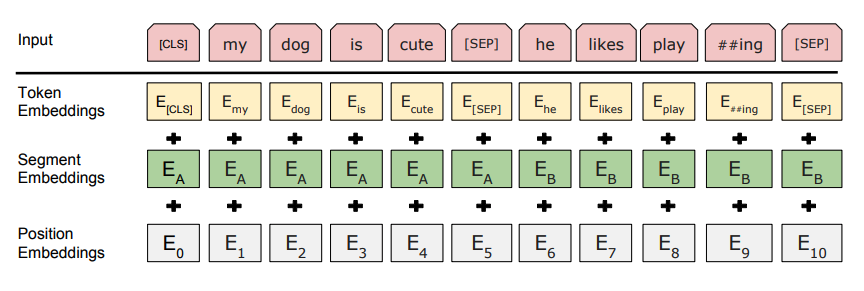

In [99]:
Image(filename="imgs/embedding.png")

Your first task is to implement the embedding lookup, including the addition of positional encodings. Open the file `Transformer.py` and complete all code parts for `Deliverable 1`.

In [149]:
from models.Transformer import TransformerTranslator
inputs = train_inxs[0:2]
inputs = torch.LongTensor(inputs)

model = TransformerTranslator(input_size=len(word_to_ix), output_size=2, device=device, hidden_dim=128, num_heads=2, dim_feedforward=2048, dim_k=96, dim_v=96, dim_q=96, max_length=train_inxs.shape[1])

embeds = model.embed(inputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(embeds, d1)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

Difference: 0.0010500667849555612


## **4.2: Multi-head Self-Attention**

Attention can be computed in matrix-form using the following formula:

In [ ]:
Image(filename="imgs/attn.png")

We want to have multiple self-attention operations, computed in parallel. Each of these is called a *head*. We concatenate the heads and multiply them with the matrix `attention_head_projection` to produce the output of this layer.

After every multi-head self-attention and feedforward layer, there is a residual connection + layer normalization. Make sure to implement this, using the following formula: 




In [ ]:
Image(filename="imgs/layer_norm.png")

Open the file `models/transformer.py` and implement the `multihead_attention` function. 
We have already initialized all of the layers you will need in the constructor.

In [150]:
hidden_states = model.multi_head_attention(embeds)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(hidden_states, d2)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

Difference: 0.000993787543848157


## **4.3: Element-Wise Feed-forward Layer**

Open the file `models/transformer.py` and complete code for `Deliverable 3`: the element-wise feed-forward layer consisting of two linear transformers with a ReLU layer in between.




In [ ]:
Image(filename="imgs/ffn.png")

In [151]:
outputs = model.feedforward_layer(hidden_states)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(outputs, d3)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

scores = model.final_layer(outputs)


Difference: 0.0010007137898355722


## **4.4: Final Layer**

Open the file `models/transformer.py` and complete code for `Deliverable 4`, to produce probability scores for all tokens in target language.

In [152]:
scores = model.final_layer(outputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(scores, d4)).item()) # should be very small (<3e-5)
except:
    print("NOT IMPLEMENTED")

Difference: 0.00012347909796517342


## **4.5: Putting it all together**

Open the file `models/transformer.py` and complete the method `forward`, by putting together all of the methods you have developed in the right order to perform a full forward pass.


In [153]:
inputs = train_inxs[0:2]
inputs = torch.LongTensor(inputs)
inputs.to(device)
outputs = model.forward(inputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(outputs, scores)).item()) # should be very small (<3e-5)
except:
    print("NOT IMPLEMENTED")

Difference: 0.00012162235361756757


Great! We've just implemented a Transformer forward pass for translation. One of the big perks of using PyTorch is that with a simple training loop, we can rely on automatic differentation ([autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) to do the work of the backward pass for us. This is not required for this assignment, but you can explore this on your own.

## **4.6: Train the Transformer**
Now you can start training the Transformer translator. We provided you with some training code and you can simply run them to see how your translator works. If you implemented everything correctly, you should see some meaningful translation in the output. Compare the results from the Seq2Seq model, which one is better? You can modify the hyperparameters to improve the results. You can also tune the BATCH_SIZE in section 1.2.

In [200]:
# Hyperparameters
learning_rate = 0.0005
EPOCHS = 10

# Model
trans_model = TransformerTranslator(input_size, output_size, device, max_length = MAX_LEN).to(device)

# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(trans_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 4.5879. Validation Loss: 3.8173. 
Training Perplexity: 98.2892. Validation Perplexity: 45.4797. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.8049. Validation Loss: 3.6199. 
Training Perplexity: 44.9195. Validation Perplexity: 37.3340. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.6050. Validation Loss: 3.4852. 
Training Perplexity: 36.7818. Validation Perplexity: 32.6275. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.4507. Validation Loss: 3.3874. 
Training Perplexity: 31.5233. Validation Perplexity: 29.5883. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.3223. Validation Loss: 3.3174. 
Training Perplexity: 27.7236. Validation Perplexity: 27.5885. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.2149. Validation Loss: 3.2672. 
Training Perplexity: 24.9010. Validation Perplexity: 26.2366. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.1239. Validation Loss: 3.2308. 
Training Perplexity: 22.7356. Validation Perplexity: 25.2999. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.0443. Validation Loss: 3.2045. 
Training Perplexity: 20.9958. Validation Perplexity: 24.6441. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 2.9725. Validation Loss: 3.1856. 
Training Perplexity: 19.5409. Validation Perplexity: 24.1824. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 2.9061. Validation Loss: 3.1734. 
Training Perplexity: 18.2848. Validation Perplexity: 23.8875. 


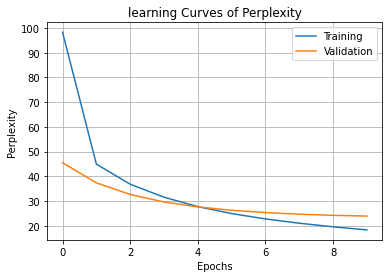

In [165]:
train_perplexity_history = []
valid_perplexity_history = []

for epoch_idx in range(EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, avg_train_loss = train(trans_model, train_loader, optimizer, criterion, device=device)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = evaluate(trans_model, valid_loader, criterion, device=device)

    print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))
    print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " % (np.exp(avg_train_loss), np.exp(avg_val_loss)))
    train_perplexity_history.append(np.exp(avg_train_loss))
    valid_perplexity_history.append(np.exp(avg_val_loss))
    
plot_curves(train_perplexity_history, valid_perplexity_history)

**Translations**

Run the code below to see some of your translations. Modify to your liking.

In [201]:
def translate(model, dataloader):
    model.eval()
    with torch.no_grad():
        # Get the progress bar 
        progress_bar = tqdm(dataloader, ascii = True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[0].transpose(1,0).to(device)
            target = data[1].transpose(1,0).to(device)

            translation = model(source)
            return target, translation

In [220]:
# Select Transformer or Seq2Seq model
# model = trans_model
model = seq2seq_model

In [221]:
#Set model equal to trans_model or seq2seq_model
target, translation = translate(model, test_loader)

  0%|          | 0/7 [00:04<?, ?it/s]


In [222]:
#Get the english sentences
raw = np.array([list(map(lambda x: en_vocab.get_itos()[x], target[i])) for i in range(target.shape[0])])

In [223]:
raw[0:9]

array([['<sos>', 'a', 'man', 'in', 'an', 'orange', 'hat', 'starring',
        'at', 'something', '.', '\n', '<eos>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>'],
       ['<sos>', 'a', '<unk>', 'terrier', 'is', 'running', 'on', 'lush',
        'green', 'grass', 'in', 'front', 'of', 'a', 'white', 'fence',
        '.', '\n', '<eos>', '<pad>'],
       ['<sos>', 'a', 'girl', 'in', 'karate', 'uniform', 'breaking', 'a',
        'stick', 'with', 'a', 'front', 'kick', '.', '\n', '<eos>',
        '<pad>', '<pad>', '<pad>', '<pad>'],
       ['<sos>', 'people', 'are', 'fixing', 'the', 'roof', 'of', 'a',
        'house', '.', '\n', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>'],
       ['<sos>', 'a', 'group', 'of', 'people', 'standing', 'in', 'front',
        'of', 'an', 'igloo', '.', '\n', '<eos>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>'],
       ['<sos>', 'a', 'guy', 'works', 'on', 'a', 'building', '.', '\n'

In [206]:
#Get the back translations for comparison
token_trans = np.argmax(translation.cpu().numpy(), axis = 2)
translated = np.array([list(map(lambda x: en_vocab.get_itos()[x], token_trans[i])) for i in range(token_trans.shape[0])])

In [224]:
translated[0:9]

array([['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'a', '.',
        '.', '\n', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>',
        '<eos>', '<eos>'],
       ['<sos>', 'a', 'man', 'is', 'is', 'a', 'a', 'a', 'a', 'a', 'a',
        'a', 'a', '.', '.', '\n', '<eos>', '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'a', 'man', 'in', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
        'a', '.', '.', '\n', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'people', 'are', 'a', 'a', 'a', 'a', 'a', '.', '.',
        '\n', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>',
        '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'a', 'group', 'of', 'people', 'are', 'in', 'front', 'a',
        'a', '.', '.', '\n', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>',
        '<eos>', '<eos>'],
       ['<sos>', 'a', 'man', 'is', 'on', 'a', 'a', '.', '.', '\n',
        '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>',
        '<eos>', '<eos>', '<eos>'],
       ['<sos>', '